<a href="https://colab.research.google.com/github/pranshurastogi29/competitions_other_than_kaggle/blob/master/Auto_tag_Images_of_the_Gala.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"pranshu29","key":"6c19500485b582ddf5a2580a4e59f0cb"}'}

In [0]:
!ls -lha kaggle.json

-rw-r--r-- 1 root root 65 Apr  2 11:47 kaggle.json


In [0]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [0]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
!kaggle datasets download -d kishor1210/image-classification-dataset-in-the-gala-event

image-classification-dataset-in-the-gala-event.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
!pip install fastai==1.0.60

In [0]:
!unzip image-classification-dataset-in-the-gala-event.zip

Streaming output truncated to the last 5000 lines.
  inflating: image_auto_tagging/Train_Images/image1844.jpg  
  inflating: image_auto_tagging/Train_Images/image1845.jpg  
  inflating: image_auto_tagging/Train_Images/image1849.jpg  
  inflating: image_auto_tagging/Train_Images/image1851.jpg  
  inflating: image_auto_tagging/Train_Images/image1852.jpg  
  inflating: image_auto_tagging/Train_Images/image1854.jpg  
  inflating: image_auto_tagging/Train_Images/image1859.jpg  
  inflating: image_auto_tagging/Train_Images/image186.jpg  
  inflating: image_auto_tagging/Train_Images/image1860.jpg  
  inflating: image_auto_tagging/Train_Images/image1861.jpg  
  inflating: image_auto_tagging/Train_Images/image1862.jpg  
  inflating: image_auto_tagging/Train_Images/image1863.jpg  
  inflating: image_auto_tagging/Train_Images/image1865.jpg  
  inflating: image_auto_tagging/Train_Images/image1868.jpg  
  inflating: image_auto_tagging/Train_Images/image187.jpg  
  inflating: image_auto_tagging/Trai

In [0]:
!pip install efficientnet_pytorch
!pip install pretrainedmodels

In [0]:
from torchvision.models import *
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
from fastai.vision.learner import model_meta
import fastai
import sys
import torch
fastai.__version__

'1.0.60'

In [0]:
import math
import torch
from torch.optim.optimizer import Optimizer, required

class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:            
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class PlainRAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)

        super(PlainRAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(PlainRAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                beta2_t = beta2 ** state['step']
                N_sma_max = 2 / (1 - beta2) - 1
                N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:                    
                    step_size = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size, exp_avg, denom)
                else:
                    step_size = group['lr'] / (1 - beta1 ** state['step'])
                    p_data_fp32.add_(-step_size, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss


class AdamW(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, warmup = 0):
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, warmup = warmup)
        super(AdamW, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                if group['warmup'] > state['step']:
                    scheduled_lr = 1e-8 + state['step'] * group['lr'] / group['warmup']
                else:
                    scheduled_lr = group['lr']

                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                
                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * scheduled_lr, p_data_fp32)

                p_data_fp32.addcdiv_(-step_size, exp_avg, denom)

                p.data.copy_(p_data_fp32)

        return loss
    
    
# Copyright (c) 2019, NVIDIA CORPORATION. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import torch
from torch.optim import Optimizer
import math

class AdamW(Optimizer):
    """Implements AdamW algorithm.
  
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
  
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
  
        Adam: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
        On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """
  
    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                  weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(AdamW, self).__init__(params, defaults)
  
    def __setstate__(self, state):
        super(AdamW, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)
  
    def step(self, closure=None):
        """Performs a single optimization step.
  
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()
  
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']
  
                state = self.state[p]
  
                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros_like(p.data)
  
                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']
  
                state['step'] += 1
                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
  
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] * math.sqrt(bias_correction2) / bias_correction1
                p.data.add_(-step_size,  torch.mul(p.data, group['weight_decay']).addcdiv_(1, exp_avg, denom) )
  
        return loss
  
class Novograd(Optimizer):
    """
    Implements Novograd algorithm.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.95, 0))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        grad_averaging: gradient averaging
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    """

    def __init__(self, params, lr=1e-3, betas=(0.95, 0), eps=1e-8,
                 weight_decay=0, grad_averaging=False, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                      weight_decay=weight_decay,
                      grad_averaging=grad_averaging,
                      amsgrad=amsgrad)

        super(Novograd, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Novograd, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
            and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Sparse gradients are not supported.')
                amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros([]).to(state['exp_avg'].device)
                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_sq'] = torch.zeros([]).to(state['exp_avg'].device)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                if amsgrad:
                    max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']

                state['step'] += 1

                norm = torch.sum(torch.pow(grad, 2))

                if exp_avg_sq == 0:
                    exp_avg_sq.copy_(norm)
                else:
                    exp_avg_sq.mul_(beta2).add_(1 - beta2, norm)

                if amsgrad:
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                    # Use the max. for normalizing running avg. of gradient
                    denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                else:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])

                grad.div_(denom)
                if group['weight_decay'] != 0:
                    grad.add_(group['weight_decay'], p.data)
                if group['grad_averaging']:
                    grad.mul_(1 - beta1)
                exp_avg.mul_(beta1).add_(grad)

                p.data.add_(-group['lr'], exp_avg)
        
        return loss
    

# Lookahead implementation from https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py

import itertools as it
from torch.optim import Optimizer, Adam

class Lookahead(Optimizer):
    def __init__(self, base_optimizer,alpha=0.5, k=6):
        if not 0.0 <= alpha <= 1.0:
            raise ValueError(f'Invalid slow update rate: {alpha}')
        if not 1 <= k:
            raise ValueError(f'Invalid lookahead steps: {k}')
        self.optimizer = base_optimizer
        self.param_groups = self.optimizer.param_groups
        self.alpha = alpha
        self.k = k
        for group in self.param_groups:
            group["step_counter"] = 0
        self.slow_weights = [[p.clone().detach() for p in group['params']]
                                for group in self.param_groups]

        for w in it.chain(*self.slow_weights):
            w.requires_grad = False
        self.state = base_optimizer.state

    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
        loss = self.optimizer.step()
        for group,slow_weights in zip(self.param_groups,self.slow_weights):
            group['step_counter'] += 1
            if group['step_counter'] % self.k != 0:
                continue
            for p,q in zip(group['params'],slow_weights):
                if p.grad is None:
                    continue
                q.data.add_(self.alpha,p.data - q.data)
                p.data.copy_(q.data)
        return loss


def LookaheadAdam(params, alpha=0.5, k=6, *args, **kwargs):
     adam = Adam(params, *args, **kwargs)
     return Lookahead(adam, alpha, k)


import torch, math
from torch.optim.optimizer import Optimizer

# RAdam + LARS
class Ralamb(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(Ralamb, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Ralamb, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('Ralamb does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                # Decay the first and second moment running average coefficient
                # m_t
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # v_t
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]

                if state['step'] == buffered[0]:
                    N_sma, radam_step = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        radam_step = group['lr'] * math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        radam_step = group['lr'] / (1 - beta1 ** state['step'])
                    buffered[2] = radam_step

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                weight_norm = p.data.pow(2).sum().sqrt().clamp(0, 10)
                radam_norm = p_data_fp32.pow(2).sum().sqrt()
                if weight_norm == 0 or radam_norm == 0:
                    trust_ratio = 1
                else:
                    trust_ratio = weight_norm / radam_norm

                state['weight_norm'] = weight_norm
                state['adam_norm'] = radam_norm
                state['trust_ratio'] = trust_ratio

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-radam_step * trust_ratio, exp_avg, denom)
                else:
                    p_data_fp32.add_(-radam_step * trust_ratio, exp_avg)

                p.data.copy_(p_data_fp32)

        return loss
    

 # RAdam + LARS + LookAHead

# Lookahead implementation from https://github.com/lonePatient/lookahead_pytorch/blob/master/optimizer.py
# RAdam + LARS implementation from https://gist.github.com/redknightlois/c4023d393eb8f92bb44b2ab582d7ec20

def Over9000(params, alpha=0.5, k=6, *args, **kwargs):
     ralamb = Ralamb(params, *args, **kwargs)
     return Lookahead(ralamb, alpha, k)

RangerLars = Over9000

In [0]:
from fastai.torch_core import *
from fastai.callback import *
from fastai.train import mixup
from fastai.callbacks.mixup import MixUpCallback, MixUpLoss
from fastai.basic_train import Learner, LearnerCallback
from fastai.vision.image import Image, TfmPixel
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="torch.nn.functional")

class RicapLoss(nn.Module):
    "Adapt the loss function `crit` to go with ricap data augmentations."

    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'):
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else:
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction

    def forward(self, output, target):
        if target.ndim == 2:
            c_ = target[:, 1:5]
            W_ = target[:, 5:]
            loss = [W_[:, k] * self.crit(output, c_[:, k].long()) for k in range(4)]
            d = torch.mean(torch.stack(loss))
        else: d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum': return d.sum()
        return d

    def get_old(self):
        if hasattr(self, 'old_crit'): return self.old_crit
        elif hasattr(self, 'old_red'):
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit

class RicapCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1811.09030
    github: https://github.com/4uiiurz1/pytorch-ricap
    and mixup in the fastai library.'''
    def __init__(self, learn:Learner, beta:float=.3, stack_y:bool=True):
        super().__init__(learn)
        self.beta,self.stack_y = beta,stack_y

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = RicapLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies ricap to `last_input` and `last_target` if `train`."
        if not train: return

        # get the image size
        I_x, I_y = last_input.size()[2:]

        # draw a boundary position (w, h)
        w = int(np.round(I_x * np.random.beta(self.beta, self.beta)))
        h = int(np.round(I_y * np.random.beta(self.beta, self.beta)))
        w_ = [w, I_x - w, w, I_x - w]
        h_ = [h, h, I_y - h, I_y - h]

        # select and crop four images
        cropped_images = {}
        bs = last_input.size(0)
        c_ = torch.zeros((bs, 4)).float().to(last_input.device)
        W_ = torch.zeros(4).float().to(last_input.device)
        for k in range(4):
            idx = torch.randperm(bs).to(last_input.device)
            x_k = np.random.randint(0, I_x - w_[k] + 1)
            y_k = np.random.randint(0, I_y - h_[k] + 1)
            cropped_images[k] = last_input[idx][:, :, x_k:x_k + w_[k], y_k:y_k + h_[k]]
            c_[:, k] = last_target[idx].float()
            W_[k] = w_[k] * h_[k] / (I_x * I_y)

        # patch cropped images
        patched_images = torch.cat(
            (torch.cat((cropped_images[0], cropped_images[1]), 2),
             torch.cat((cropped_images[2], cropped_images[3]), 2)), 3).to(last_input.device)

        # modify last target
        if self.stack_y:
                new_target = torch.cat((last_target[:,None].float(), c_,
                                        W_[None].repeat(last_target.size(0), 1)), dim=1)
        else:
            new_target = c_ * W_

        return {'last_input': patched_images, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def ricap(learn:Learner, beta:float=.3, stack_y:bool=True) -> Learner:
    "Add ricap https://arxiv.org/pdf/1811.09030.pdf to `learn`."
    learn.callback_fns.append(partial(RicapCallback, beta=beta, stack_y=stack_y))
    return learn

setattr(ricap, 'cb_fn', RicapCallback)
Learner.ricap = ricap

setattr(mixup, 'cb_fn', MixUpCallback)


class CutMixCallback(LearnerCallback):
    '''Adapted from :
    paper: https://arxiv.org/abs/1905.04899
    github: https://github.com/clovaai/CutMix-PyTorch
    and mixup in the fastai library.'''

    def __init__(self, learn:Learner, alpha:float=1., stack_y:bool=True, true_λ:bool=True):
        super().__init__(learn)
        self.alpha,self.stack_y,self.true_λ = alpha,stack_y,true_λ

    def on_train_begin(self, **kwargs):
        if self.stack_y: self.learn.loss_func = MixUpLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies cutmix to `last_input` and `last_target` if `train`."
        if not train: return
        λ = np.random.beta(self.alpha, self.alpha)
        λ = max(λ, 1- λ)
        bs = last_target.size(0)
        idx = torch.randperm(bs).to(last_input.device)
        x1, y1 = last_input[idx], last_target[idx]

        #Get new input
        last_input_size = last_input.size()
        bbx1, bby1, bbx2, bby2 = rand_bbox(last_input_size, λ)
        new_input = last_input.clone()
        new_input[..., bby1:bby2, bbx1:bbx2] = x1[..., bby1:bby2, bbx1:bbx2]
        λ = last_input.new([λ])
        λ = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (last_input_size[-1] * last_input_size[-2]))
        λ = last_input.new([λ])

        # modify last target
        if self.stack_y:
            new_target = torch.cat([last_target.unsqueeze(1).float(), y1.unsqueeze(1).float(),
                                    λ.repeat(last_input_size[0]).unsqueeze(1).float()], 1)
        else:
            if len(last_target.shape) == 2:
                λ = λ.unsqueeze(1).float()
            new_target = last_target.float() * λ + y1.float() * (1-λ)

        return {'last_input': new_input, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if self.stack_y: self.learn.loss_func = self.learn.loss_func.get_old()


def rand_bbox(last_input_size, λ):
    '''lambd is always between .5 and 1'''

    W = last_input_size[-1]
    H = last_input_size[-2]
    cut_rat = np.sqrt(1. - λ) # 0. - .707
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2


def cutmix(learn:Learner, alpha:float=1., stack_x:bool=False, stack_y:bool=True, true_λ:bool=True) -> Learner:
    "Add cutmix https://arxiv.org/pdf/1905.04899.pdf to `learn`."
    learn.callback_fns.append(partial(CutMixCallback, alpha=alpha, stack_y=stack_y, true_λ=true_λ))
    return learn

setattr(cutmix, 'cb_fn', CutMixCallback)
Learner.cutmix = cutmix


def get_x1_coords(x_size, n_patches, same_size=True):
    if same_size:
        w = np.linspace(0, x_size[-1], num=n_patches[0] + 1).astype(np.int64)
        h = np.linspace(0, x_size[-2], num=n_patches[1] + 1).astype(np.int64)
    else:
        w, h = [], []
        if n_patches[0] > 1:
            w = sorted(list(np.random.choice(np.arange(0, x_size[-1]),
                                             size= n_patches[0] - 1, replace=False)))
        if n_patches[1] > 1:
            h = sorted(list(np.random.choice(np.arange(0, x_size[-2]),
                                             size= n_patches[1] - 1, replace=False)))
        w = [0] + w + [x_size[-1]]
        h = [0] + h + [x_size[-2]]
    patch = []
    for i in range(n_patches[0]):
        for j in range(n_patches[1]):
            patch.append([h[j], h[j + 1], w[i], w[i + 1]])
    return patch


def get_x1_rand_coords(x_size, n_patches, w, h, same_size=True):
    if not same_size:
        a = w * h
        p = np.random.uniform() + .5
        w = max(1, int(p * w))
        h = max(1, int(a / w))
    w_x = np.random.randint(0, x_size[-1]) if n_patches[0] != 1 else 0
    w_xa = np.clip(w_x - w // 2, 0, x_size[-1])
    w_xb = np.clip(w_x + w // 2, 0, x_size[-1])
    h_x = np.random.randint(0, x_size[-2]) if n_patches[1] != 1 else 0
    h_xa = np.clip(h_x - h // 2, 0, x_size[-2])
    h_xb = np.clip(h_x + h // 2, 0, x_size[-2])
    return h_xa, h_xb, w_xa, w_xb


def get_x2_coords(x_size, bby1, bby2, bbx1, bbx2):
    w_ = bbx2 - bbx1
    h_ = bby2 - bby1
    w_k = np.random.randint(0, x_size[-1] - w_) if w_ != x_size[-1] else 0
    h_k = np.random.randint(0, x_size[-2] - h_) if h_ != x_size[-2] else 0
    return h_k, h_k + h_, w_k, w_k + w_


#export

class BlendLoss(nn.Module):
    "Adapt the loss function `crit` to go with blend data augmentations."

    def __init__(self, crit, reduction='mean'):
        super().__init__()
        if hasattr(crit, 'reduction'):
            self.crit = crit
            self.old_red = crit.reduction
            setattr(self.crit, 'reduction', 'none')
        else:
            self.crit = partial(crit, reduction='none')
            self.old_crit = crit
        self.reduction = reduction

    def forward(self, output, target):
        if target.ndim == 2:# and target.shape[-1] >1:
            n_mod_patches = (target.shape[-1] - 1) // 2
            c_ = target[:, 1:n_mod_patches + 1]
            W_ = target[:, n_mod_patches + 1:]
            loss = [W_[:, k] * self.crit(output, c_[:, k].long()) for k in range(n_mod_patches)]
            d = torch.mean(torch.stack(loss))
        else: d = self.crit(output, target)
        if self.reduction == 'mean': return d.mean()
        elif self.reduction == 'sum': return d.sum()
        return d

    def get_old(self):
        if hasattr(self, 'old_crit'): return self.old_crit
        elif hasattr(self, 'old_red'):
            setattr(self.crit, 'reduction', self.old_red)
            return self.crit


class BlendCallback(LearnerCallback):
    "Callback that creates the blend input and target."
    def __init__(self, learn:Learner,
                 size:tuple=(.1, .1), alpha:float=1., fixed_proba:float=0.,
                 blend_type:str='cut', grid:bool=True,
                 same_size:bool=True, same_crop:bool=True, same_image:bool=False):
        ''' Modifies one or multiple subregions of an image
        Parameters:
        size:
            int tuple(height pixels, wide pixels), float tuple (height % img, wide % img)
            int (pixels) or float (percent_tuple)
            None full image
        alpha: proba that each patch is modified from np.random.beta(alpha, alpha)
        fixed_proba: proba that each individual patch is modified. If >0 overrides alpha.
        blend_type: 'zero', 'noise', 'mix', 'cut' or 'rand'(any of the previous)
        grid: True - a grid is applied to the image so that patches never overlap (required in 'mix' and 'cut')
        same_size: True - all patches will have approx the same size, otherwise random
        same_crop: cropping subregion will be the same as input subregion, otherwise different
        same_image: False - cropping image will be different from input image, otherwise same
        '''
        assert blend_type in ['zero', 'noise', 'mix', 'cut', 'random'], \
        print("make sure you select one of these blend_types: 'zero', 'noise', 'mix', 'cut', 'random'")
        if not grid and not same_image:
            assert blend_type in ['zero', 'noise'],\
            print('either grid or same_image must be set to True when using', blend_type)
        super().__init__(learn)
        self.size,self.alpha,self.fixed_proba,self.blend_type = size,alpha,fixed_proba,blend_type
        self.grid,self.same_size,self.same_crop,self.same_image = grid,same_size,same_crop,same_image

    def on_train_begin(self, **kwargs):
        if not self.same_image: self.learn.loss_func = BlendLoss(self.learn.loss_func)

    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        "Applies blend to `last_input` and `last_target` if `train`."
        if not train: return {'last_input': last_input, 'last_target': last_target}
        if self.alpha == 0 and self.fixed_proba == 0:
            return {'last_input': last_input, 'last_target': last_target}

        x_size = last_input.size()
        bs = x_size[0] # batch size
        i_h, i_w = x_size[2:] # image height, width
        if not isinstance(self.size, tuple): self.size = (self.size, self.size)
        p_h, p_w = self.size # patch percent height, width
        if p_h == 1 or isinstance(p_h, float): h = int(p_h * i_h) # patch height in pixels
        else: h = p_h
        if p_w == 1 or isinstance(p_w, float): w = int(p_w * i_w) # patch width in pixels
        else: w = p_w
        if w == 0 or h == 0: return {'last_input': last_input, 'last_target': last_target}
        patched_images = last_input.clone()

        # patches that will be modified
        n_patches = (i_h // h, i_w // w)
        patch_len = n_patches[0] * n_patches[1]
        patches = get_x1_coords(x_size, n_patches, same_size=self.same_size)
        if self.fixed_proba != 0:
            lambd = self.fixed_proba
        else:
            lambd = np.random.beta(self.alpha, self.alpha)
            lambd = max(lambd, 1- lambd)
        if patch_len == 1: patch_ids = [0]
        elif self.fixed_proba != 0:
            patch_ids = np.arange(patch_len)[np.random.rand(patch_len) <= lambd]
        else:
            patch_ids = np.random.choice(np.arange(patch_len), int(patch_len * (1 - lambd)), replace=False)
        n_mod_patches = len(patch_ids)
        if n_mod_patches == 0: return {'last_input': last_input, 'last_target': last_target}
        #mod_patches = [patches[i] for i in patch_ids]
        c_ = torch.zeros((bs, n_mod_patches)).float().to(last_input.device) # patch labels
        W_ = torch.zeros(n_mod_patches).float().to(last_input.device) # new weights
        idx = torch.linspace(0, bs - 1, steps=bs).to(dtype=torch.int64, device=last_input.device)
        if self.blend_type.lower() == 'random': _blend = np.random.choice(['zero', 'noise', 'mix', 'cut'])
        else: _blend = self.blend_type.lower()
        for i,j in enumerate(patch_ids):
            #x1 coordinates
            if self.grid: bby1, bby2, bbx1, bbx2 = patches[j]
            else: bby1, bby2, bbx1, bbx2 = get_x1_rand_coords(x_size, n_patches, w, h,
                                                              same_size=self.same_size)
            # Blend
            if _blend == 'zero': patched_images[..., bby1:bby2, bbx1:bbx2] = 0
            if _blend == 'noise':
                noise = last_input.new(np.random.rand(bby2 - bby1, bbx2 - bbx1))
                patched_images[..., bby1:bby2, bbx1:bbx2] = noise
            else:
                if not self.same_image: idx = torch.randperm(bs).to(last_input.device)
                #x2 coordinates
                if self.same_crop:
                    x2 = last_input[idx][..., bby1:bby2, bbx1:bbx2]
                else:
                    ccy1, ccy2, ccx1, ccx2 = get_x2_coords(x_size, bby1, bby2, bbx1, bbx2)
                    x2 = last_input[idx][..., ccy1:ccy2, ccx1:ccx2]
                if _blend == 'mix':
                    x1 = last_input[..., bby1:bby2, bbx1:bbx2]
                    if self.size == (1, 1):
                        patched_images[..., bby1:bby2, bbx1:bbx2] = x1 * lambd + x2 * (1 - lambd)
                    else: patched_images[..., bby1:bby2, bbx1:bbx2] = x1 * .5 + x2 * .5
                if _blend == 'cut':
                    patched_images[..., bby1:bby2, bbx1:bbx2] = x2
            W_[i] = (bby2 - bby1) * (bbx2 - bbx1) / (i_w * i_h)
            c_[:, i] = last_target[idx].float()
        # modify last target
        if not self.same_image and n_mod_patches > 0:
            new_target = torch.cat((last_target[:,None].float(), c_, W_[None].repeat(bs, 1)), dim=1)
        else: new_target = last_target
        return {'last_input': patched_images, 'last_target': new_target}

    def on_train_end(self, **kwargs):
        if not self.same_image: self.learn.loss_func = self.learn.loss_func.get_old()


def blend(learn:Learner, size:tuple=(.1, .1), alpha:float=1., fixed_proba:float=0.,
                 blend_type:str='cut', grid:bool=True,
                 same_size:bool=True, same_crop:bool=True, same_image:bool=False) -> Learner:
    learn.callback_fns.append(partial(BlendCallback, size=size, alpha=alpha,
                                      fixed_proba=fixed_proba, blend_type=blend_type, grid=grid,
                                      same_size=same_size, same_crop=same_crop, same_image=same_image))
    return learn

setattr(blend, 'cb_fn', BlendCallback)
Learner.blend = blend


import math

class TfmScheduler(LearnerCallback):

    def __init__(self,
                 learn: Learner,
                 tfm_fn: Callable,
                 sch_param: Union[str, StrList],
                 sch_val: Union[StartOptEnd, List],
                 sch_iter: Optional[StartOptEnd] = None,
                 sch_func: Optional[AnnealFunc] = None,
                 plot: bool = False,
                 test: bool = False,
                 **kwargs: Any):

        super().__init__(learn)
        self.learn = learn
        self.batches = math.ceil(len(learn.data.train_ds)/learn.data.train_dl.batch_size)
        sch_param = listify(sch_param)
        if isinstance(sch_param, (float, int)): sch_val = (0, sch_val)
        sch_val = tuplify(sch_val)
        if len(sch_param) != len(sch_val): sch_val = sch_val * len(sch_param)
        assert len(sch_param) == len(sch_val)
        if sch_iter is None: sch_iter = (0., 1.)
        sch_iter = tuplify(sch_iter)
        if len(sch_param) != len(sch_iter): sch_iter = sch_iter * len(sch_param)
        assert len(sch_param) == len(sch_iter)
        self.tfm_fn,self.sch_param,self.sch_val,self.sch_iter,self.test = tfm_fn,sch_param,sch_val,sch_iter,test
        if sch_func is None: sch_func = annealing_linear
        sch_func = listify(sch_func)
        if len(sch_param) != len(sch_func): sch_func = sch_func * len(sch_param)
        assert len(sch_param) == len(sch_func)
        self.sch_func = sch_func
        self.plot = plot
        if not isinstance(self.tfm_fn, functools.partial): self.tfm_fn = partial(self.tfm_fn)
        self.fn = get_fn(self.tfm_fn)
        if hasattr(self.fn, 'cb_fn'): self.fn = self.fn.cb_fn
        if hasattr(self.fn, 'on_batch_begin'): self.cb = True
        else: self.cb = False


    def on_train_begin(self, n_epochs: int, epoch: int, **kwargs: Any):
        if self.cb: self.fn(self.learn).on_train_begin()
        total_iters = n_epochs * self.batches
        self.scheduler = [None] * len(self.sch_param)
        for i in range(len(self.sch_param)):
            p = self.sch_param[i]
            v = self.sch_val[i]
            iters = self.sch_iter[i]
            func = self.sch_func[i]
            self.scheduler[i] = MyScheduler(total_iters, v, sch_iter=iters, sch_func=func)
            s = self.scheduler[i]
            a = s.start_val
            a_ = []
            first_iter = -1
            last_iter = 1
            for i in range(total_iters):
                a = s.step()
                if i > 0 and first_iter == -1 and a != a_[-1]: first_iter = (i - 1) / total_iters
                elif first_iter != -1 and last_iter == 1 and a == a_[-1]: last_iter = i / total_iters
                a_.append(a)
            s.restart()
            text = '{} between {} and {} in iters {:.2f} to {:.2f}'.format(
                p, round(min(a_), 5), round(max(a_), 5), first_iter, last_iter)
            print('\n',text)
            if self.plot:
                plt.plot(a_)
                plt.title(text)
                plt.show()


    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        if self.test: return {'stop_epoch': True, 'stop_training': True, 'skip_validate': True}
        if train:
            for i, (p, v) in enumerate(zip(self.sch_param, self.sch_val)):
                new_v = self.scheduler[i].step()
                self.tfm_fn.keywords[p] = new_v
            kw = self.tfm_fn.keywords
            if self.cb:
                return self.fn(self.learn, **kw).on_batch_begin(
                    last_input=last_input,last_target=last_target,train=train)
            else:
                new_input = self.fn(last_input, **kw)
                return {'last_input': new_input, 'last_target': last_target}
        else: return

    def on_train_end(self, **kwargs):
        if self.cb: self.fn(self.learn).on_train_end()


class MyScheduler():
    "Used to \"step\" from start,end (`vals`) over `n_iter` iterations on a schedule defined by `func`"
    def __init__(self, total_iters:int, sch_val:StartOptEnd, sch_iter:Optional[StartOptEnd]=None,
                 sch_func:Optional[AnnealFunc]=None):
        self.total_iters = total_iters
        self.start_val,self.end_val = (sch_val[0],sch_val[1]) if is_tuple(sch_val) else (0, sch_val)
        if sch_iter is None: self.start_iter,self.end_iter = (0, total_iters)
        else:
            self.start_iter,self.end_iter = (sch_iter[0],sch_iter[1]) if is_tuple(sch_iter) else (0, sch_iter)
            if self.start_iter == 1 or isinstance(self.start_iter, float):
                self.start_iter = int(self.start_iter * total_iters)
            if self.end_iter == 1 or isinstance(self.end_iter, float):
                self.end_iter = int(self.end_iter * total_iters)
        self.eff_iters = self.end_iter - self.start_iter
        if sch_func is None: self.sch_func = annealing_linear
        else: self.sch_func = sch_func
        self.n = 0

    def restart(self): self.n = 0

    def step(self)->Number:
        "Return next value along annealed schedule."
        self.eff_n = min(max(0, self.n - self.start_iter), self.eff_iters)
        out = self.sch_func(self.start_val, self.end_val, min(1, self.eff_n/(self.eff_iters - 1)))
        self.n += 1
        return out


def cosine_annealing(start:Number, end:Number, pct:float, pct_start=.3, **kwargs)->Number:
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    if pct <= pct_start:
        return annealing_cos(start, end, pct/pct_start)
    else:
        return annealing_cos(end, start, (pct - pct_start)/(1 - pct_start))

def inv_annealing_poly(start:Number, end:Number, pct:float, degree:Number, **kwargs)->Number:
    "Helper function for `inv_anneal_poly`."
    return start + (end - start) * (pct)**degree

def inv_annealing_cos(start:Number, end:Number, pct:float, **kwargs)->Number:
    "Cosine anneal from `start` to `end` as pct goes from 0.0 to 1.0."
    cos_out = np.cos(np.pi * pct) + 1
    return start + (end - start)/2 * cos_out

def tuplify(a):
    if not isinstance(a, list): a = [a]
    for i, x in enumerate(a):
        if not isinstance(x, tuple): a[i] = (0, x)
    return a

def get_fn(a):
    while True:
        if hasattr(a, 'func'): a = a.func
        else: break
    return a



def show_multi_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    tfms = learn.data.train_ds.tfms
    for i in range(len(xb)):
        xb[i] = Image(xb[i]).apply_tfms(tfms).data
    for cb in learn.callback_fns:
        try:
            cb_fn = partial(cb.func, **cb.keywords)
            [Image(cb_fn(learn).on_batch_begin(
                        xb, yb, True)['last_input'][0]).show(ax=ax)
                for i, ax in enumerate(
                    plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
            plt.show()
            break
        except:
            plt.close('all')
    return learn


Learner.show_multi_img_tfms = show_multi_img_tfms


def show_single_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    img = learn.data.train_ds.x
    tfms = learn.data.train_ds.tfms
    rand_int = np.random.randint(len(img))
    [img[rand_int].apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(
            plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
    plt.show()
    return learn

def show_multi_img_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    tfms = learn.data.train_ds.tfms
    for i in range(len(xb)):
        xb[i] = Image(xb[i]).apply_tfms(tfms).data
    for cb in learn.callback_fns:
        try:
            cb_fn = partial(cb.func, **cb.keywords)
            [Image(cb_fn(learn).on_batch_begin(
                        xb, yb, True)['last_input'][0]).show(ax=ax)
                for i, ax in enumerate(
                    plt.subplots(rows, cols, figsize=figsize)[1].flatten())]
            plt.show()
            break
        except:
            plt.close('all')
    return learn

def show_tfms(learn, rows=3, cols=3, figsize=(8, 8)):
    xb, yb = learn.data.one_batch()
    rand_int = np.random.randint(len(xb))
    rand_img = Image(xb[rand_int])
    tfms = learn.data.train_ds.tfms
    for i in range(len(xb)):
        xb[i] = Image(xb[i]).apply_tfms(tfms).data
    cb_tfms = 0
    for cb in learn.callback_fns:
        if hasattr(cb, 'keywords') and hasattr(get_fn(cb), 'on_batch_begin'):
            cb_fn = partial(get_fn(cb), **cb.keywords)
            try:
                fig = plt.subplots(rows, cols, figsize=figsize)[1].flatten()
                plt.suptitle(get_fn(cb).__name__, size=14)
                [Image(cb_fn(learn).on_batch_begin(
                            xb, yb, True)['last_input'][0]).show(ax=ax)
                    for i, ax in enumerate(fig)]
                plt.show()
                cb_tfms += 1
                break
            except:
                plt.close('all')
    if cb_tfms == 0:
        if tfms is not None:
            t_ = []
            for t in learn.data.train_ds.tfms: t_.append(get_fn(t).__name__)
            title = f"{str(t_)[1:-1]} transforms applied"
        else: title = f'No transform applied'
        rand_int = np.random.randint(len(xb))
        fig = plt.subplots(rows, cols, figsize=figsize)[1].flatten()
        plt.suptitle(title, size=14)
        [rand_img.apply_tfms(tfms).show(ax=ax) for i, ax in enumerate(fig)]
        plt.show()
    return learn

Learner.show_tfms = show_tfms
Learner.show_multi_img_tfms = show_multi_img_tfms
Learner.show_single_img_tfms = show_single_img_tfms

In [0]:
import os
os.listdir()

['.config',
 'submission.csv',
 'image_auto_tagging',
 'kaggle (1).json',
 'kaggle.json',
 'image-classification-dataset-in-the-gala-event.zip',
 'sample_data']

In [0]:
path="image_auto_tagging/"

In [0]:
df = pd.read_csv(path+'train.csv')
sub = pd.read_csv(path+'test.csv')

In [0]:
SZ = 128
BS = 128

In [0]:
def get_data(bs, size):
    tfms = get_transforms(max_zoom=1.9,max_rotate=80.0,
                      max_warp=0.2, p_affine=0.75,do_flip=True)
    tfms1 = tfms
    data = (ImageList.from_csv(path, folder = 'Train_Images',csv_name='train.csv')
        .split_by_rand_pct(.2,seed=42)              
        .label_from_df()            
        .add_test_folder(test_folder = 'Test_Images')              
        .transform(tfms, size=SZ)
        .databunch(num_workers=12,bs=BS))
    return data
data = get_data(bs=BS, size=SZ)

In [0]:
from efficientnet_pytorch import EfficientNet
from fastai.callbacks import *

In [0]:
from fastai.vision.models.cadene_models import *
import pretrainedmodels

In [0]:
model_name = 'efficientnet-b5'
def get_model(pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features, data.c)
    return model
learn = Learner(data,get_model(),model_dir="/tmp/model",
                metrics=[FBeta(average = 'weighted')],
                opt_func = Over9000,
                wd=1e-2,callback_fns=[ShowGraph]).mixup()

Loaded pretrained weights for efficientnet-b5


epoch,train_loss,valid_loss,f_beta,time
0,1.397393,1.369794,0.301636,00:41
1,1.392549,1.363255,0.317067,00:41
2,1.386164,1.351167,0.347192,00:41
3,1.375754,1.334947,0.386797,00:41
4,1.356586,1.304721,0.443326,00:41
5,1.334733,1.263937,0.511641,00:41
6,1.302947,1.197417,0.582706,00:41
7,1.260070,1.088910,0.613037,00:41
8,1.205954,0.975792,0.643046,00:42
9,1.147051,0.869320,0.669140,00:42


Better model found at epoch 0 with f_beta value: 0.30163562297821045.


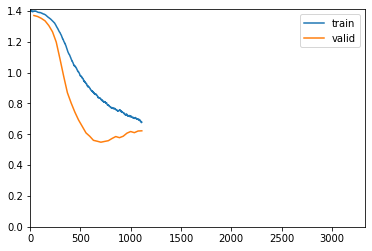

Better model found at epoch 1 with f_beta value: 0.31706660985946655.
Better model found at epoch 2 with f_beta value: 0.3471921980381012.
Better model found at epoch 3 with f_beta value: 0.38679665327072144.
Better model found at epoch 4 with f_beta value: 0.4433256685733795.
Better model found at epoch 5 with f_beta value: 0.5116410851478577.
Better model found at epoch 6 with f_beta value: 0.5827057361602783.
Better model found at epoch 7 with f_beta value: 0.6130369305610657.
Better model found at epoch 8 with f_beta value: 0.6430461406707764.
Better model found at epoch 9 with f_beta value: 0.6691399812698364.
Better model found at epoch 10 with f_beta value: 0.687209963798523.
Better model found at epoch 11 with f_beta value: 0.7197393178939819.
Better model found at epoch 12 with f_beta value: 0.7492209672927856.
Better model found at epoch 13 with f_beta value: 0.7664613127708435.
Better model found at epoch 14 with f_beta value: 0.7858893871307373.
Better model found at epoch 

In [0]:
learn.callbacks=[SaveModelCallback(learn,every='improvement', monitor='f_beta')]
learn.fit_one_cycle(90,2e-3)

In [0]:
models.__dict__

{'BasicBlock': fastai.vision.models.wrn.BasicBlock,
 'Darknet': fastai.vision.models.darknet.Darknet,
 'DynamicUnet': fastai.vision.models.unet.DynamicUnet,
 'ResLayer': fastai.vision.models.darknet.ResLayer,
 'ResNet': torchvision.models.resnet.ResNet,
 'SqueezeNet': torchvision.models.squeezenet.SqueezeNet,
 'UnetBlock': fastai.vision.models.unet.UnetBlock,
 'WideResNet': fastai.vision.models.wrn.WideResNet,
 'XResNet': fastai.vision.models.xresnet.XResNet,
 '__builtins__': {'ArithmeticError': ArithmeticError,
  'AssertionError': AssertionError,
  'AttributeError': AttributeError,
  'BaseException': BaseException,
  'BlockingIOError': BlockingIOError,
  'BrokenPipeError': BrokenPipeError,
  'BufferError': BufferError,
  'BytesWarning': BytesWarning,
  'ChildProcessError': ChildProcessError,
  'ConnectionAbortedError': ConnectionAbortedError,
  'ConnectionError': ConnectionError,
  'ConnectionRefusedError': ConnectionRefusedError,
  'ConnectionResetError': ConnectionResetError,
  'Dep

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


epoch,train_loss,valid_loss,f_beta,time
0,1.801401,1.420467,0.323379,00:20


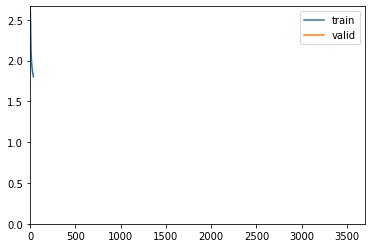

Better model found at epoch 0 with f_beta value: 0.32337862253189087.


In [0]:
learn = cnn_learner(data,models.resnet101 ,wd=1e-2, ps=0.5,metrics=[FBeta(beta = 4,average = 'weighted')],
                    model_dir="/tmp/model",opt_func = Over9000,callback_fns=[ShowGraph]).mixup()
learn.fit_one_cycle(100, max_lr=slice(1e-3,1e-2),callbacks=[SaveModelCallback(learn,every='improvement', monitor='f_beta')])

In [0]:
learn = cnn_learner(get_data(224,64), models.resnet152,wd=1e-2, ps=0.5,metrics=[FBeta(beta = 4,average = 'weighted')],callback_fns=[ShowGraph]).mixup()

In [0]:
learn.load('/tmp/model/bestmodel')
learn.model_dir="/tmp/model1"
#learn.callbacks = [SaveModelCallback(learn,every='improvement', monitor='f_beta')]

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


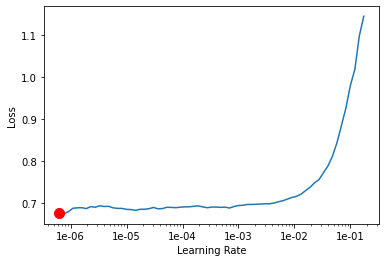

In [0]:
learn.lr_find()

Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


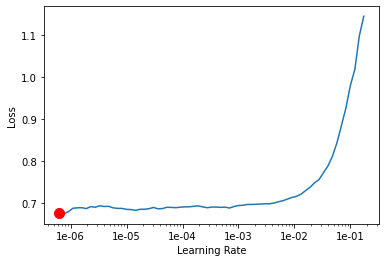

In [0]:
learn.recorder.plot(suggestion=True)

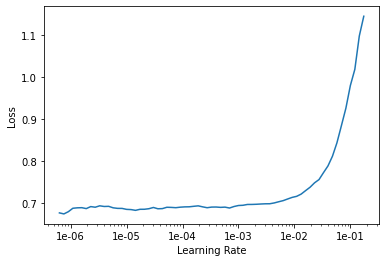

In [0]:
learn.recorder.plot(skip_ends=5)

epoch,train_loss,valid_loss,f_beta,time
0,0.688507,0.444016,0.852324,00:21
1,0.686525,0.442216,0.850731,00:21
2,0.685064,0.442637,0.849008,00:21
3,0.690993,0.444932,0.848156,00:21
4,0.689295,0.441330,0.849089,00:21
5,0.688426,0.444431,0.850652,00:21
6,0.693728,0.444967,0.849757,00:21
7,0.688501,0.442492,0.847368,00:21
8,0.687845,0.441294,0.849898,00:21
9,0.695939,0.444743,0.849816,00:21


Better model found at epoch 0 with f_beta value: 0.8523240089416504.


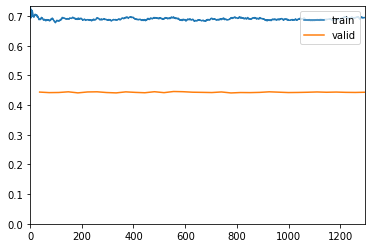

Better model found at epoch 0 with f_beta value: 0.8523240089416504.
Better model found at epoch 13 with f_beta value: 0.8532109260559082.
Better model found at epoch 13 with f_beta value: 0.8532109260559082.


In [0]:
learn.model_dir="/tmp/model1"
learn.fit_one_cycle(35,max_lr=1e-6,callbacks=[SaveModelCallback(learn,every='improvement', monitor='f_beta')])

In [0]:
learn.load('/tmp/model1/bestmodel')

Learner(data=ImageDataBunch;

Train: LabelList (4787 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Food,misc,Attire,Food,Attire
Path: image_auto_tagging;

Valid: LabelList (1196 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Attire,Food,Food,misc,Food
Path: image_auto_tagging;

Test: LabelList (3219 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: image_auto_tagging, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      

In [0]:
sub

,Image
0,image6245.jpg
1,image10409.jpg
2,image8692.jpg
3,image10517.jpg
4,image2580.jpg
...,...
3214,image4968.jpg
3215,image6673.jpg
3216,image3442.jpg
3217,image8178.jpg


In [0]:
preds

(tensor([[0.5842, 0.0175, 0.3290, 0.0693],
         [0.8705, 0.0091, 0.1056, 0.0148],
         [0.7227, 0.0927, 0.0565, 0.1281],
         ...,
         [0.1862, 0.0451, 0.6363, 0.1324],
         [0.8071, 0.0118, 0.1142, 0.0669],
         [0.0061, 0.9456, 0.0160, 0.0322]]), tensor([0, 0, 0,  ..., 0, 0, 0]))

In [0]:
preds,_ = learn.TTA(ds_type=DatasetType.Test)
labelled_preds = []
pred13 = preds
for pred in pred13:
    labelled_preds.append(int(np.argmax(pred)))

submission1 = pd.DataFrame(
    {'Image': sub.Image.values,
     'Class': labelled_preds,
    })
submission1.to_csv('submission.csv',index=False)
import pandas as pd
import numpy as np
df =pd.read_csv('submission.csv')
a = df.Class.values
b = ['Attire', 'Decorationandsignage', 'Food', 'misc']
l = []
for i in range(len(a)):
    if a[i] == 0:
        l.append(b[0])
    if a[i] == 1:
        l.append(b[1])
    if a[i] == 2:
        l.append(b[2])
    if a[i] == 3:
        l.append(b[3])
df['Class']=pd.Series(l)
df.to_csv('submission.csv',index=False)

In [0]:
sz = 256; i = 7
learn = cnn_learner(get_data(sz, 32), models.resnet152,wd=1e-2, 
                    metrics=[FBeta(beta = 4,average = 'weighted')],model_dir='/tmp/model')
learn.load('/tmp/model1/bestmodel')

Learner(data=ImageDataBunch;

Train: LabelList (4787 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Food,misc,Attire,Food,Attire
Path: image_auto_tagging;

Valid: LabelList (1196 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Attire,Food,Food,misc,Food
Path: image_auto_tagging;

Test: LabelList (3219 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: image_auto_tagging, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 1.20E-04


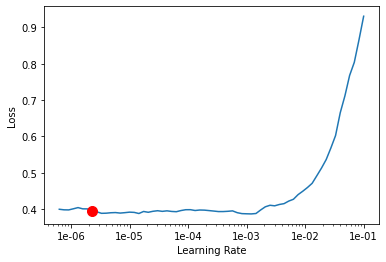

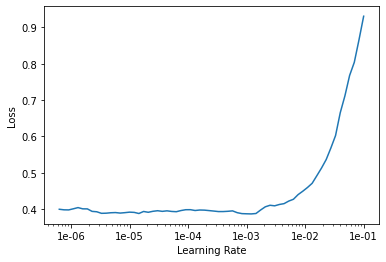

In [0]:
learn.lr_find()
learn.recorder.plot(suggestion= True)
learn.recorder.plot(skip_ends=5)

In [0]:
learn.fit_one_cycle(50,max_lr=1e-3,callbacks=[SaveModelCallback(learn,every='improvement', monitor='f_beta')])

epoch,train_loss,valid_loss,f_beta,time
0,0.391225,0.440095,0.847314,00:22
1,0.372110,0.439349,0.848900,00:21
2,0.356619,0.439622,0.848148,00:21
3,0.352720,0.446409,0.842461,00:21
4,0.352761,0.467711,0.837361,00:21
5,0.347714,0.484350,0.840044,00:21
6,0.361731,0.487366,0.835109,00:21
7,0.361737,0.511032,0.835751,00:21
8,0.369163,0.507376,0.828994,00:21
9,0.379647,0.506536,0.820074,00:21


Better model found at epoch 0 with f_beta value: 0.8473140597343445.
Better model found at epoch 1 with f_beta value: 0.8489003777503967.


In [0]:
learn50 = cnn_learner(get_data(256, 32),models.resnet152,ps=.5,wd=1e-2,model_dir='/tmp/model',metrics=[FBeta(beta = 4,average = 'weighted')]).load('/tmp/model1/bestmodel')
learn50.lr_find()

ERROR! Session/line number was not unique in database. History logging moved to new session 63


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


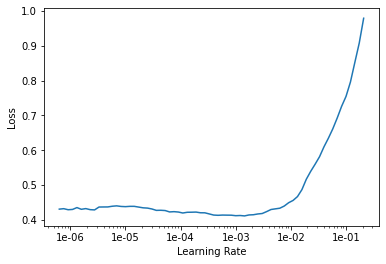

In [0]:
learn50.recorder.plot(skip_end=5)

Min numerical gradient: 3.02E-05
Min loss divided by 10: 1.45E-04


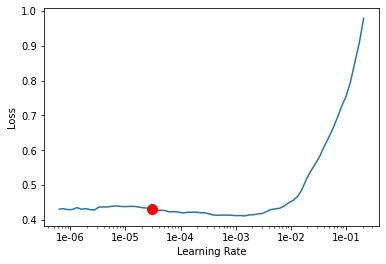

In [0]:
learn50.recorder.plot(suggestion=True)

In [0]:
learn50.model_dri=['/tmp/model3']
learn50.fit_one_cycle(35,3e-5,callbacks=[SaveModelCallback(learn50,every='improvement', monitor='f_beta')])

epoch,train_loss,valid_loss,f_beta,time
0,0.432307,0.452035,0.858220,00:20
1,0.429740,0.451791,0.859930,00:20
2,0.421551,0.447365,0.859932,00:20
3,0.416581,0.445577,0.857192,00:20
4,0.409106,0.441189,0.853948,00:19
5,0.405459,0.437122,0.849758,00:20
6,0.399773,0.437339,0.852189,00:20
7,0.387212,0.433557,0.851392,00:20
8,0.382854,0.430798,0.848971,00:20
9,0.380425,0.430607,0.847317,00:20


Better model found at epoch 0 with f_beta value: 0.8582202196121216.
Better model found at epoch 1 with f_beta value: 0.859930157661438.
Better model found at epoch 2 with f_beta value: 0.8599320650100708.


In [0]:
learn50 = cnn_learner(get_data(256, 32),models.resnet152,ps=.5,wd=1e-2,model_dir='/tmp/model',metrics=[FBeta(beta = 4,average = 'weighted')]).load('/tmp/model3/bestmodel')

In [0]:
def find_appropriate_lr(model:Learner, lr_diff:int = 15, loss_threshold:float = .05, adjust_value:float = 1, plot:bool = True) -> float:
    #Run the Learning Rate Finder
    model.lr_find()
    
    #Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    assert(lr_diff < len(losses))
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs
    
    #Search for index in gradients where loss is lowest before the loss spike
    #Initialize right and left idx using the lr_diff as a spacing unit
    #Set the local min lr as -1 to signify if threshold is too low
    r_idx = -1
    l_idx = r_idx - lr_diff
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        local_min_lr = lrs[l_idx]
        r_idx -= 1
        l_idx -= 1

    lr_to_use = local_min_lr * adjust_value
    
    if plot:
        # plots the gradients of the losses in respect to the learning rate change
        plt.plot(loss_grad)
        plt.plot(len(losses)+l_idx, loss_grad[l_idx],markersize=10,marker='o',color='red')
        plt.ylabel("Loss")
        plt.xlabel("Index of LRs")
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel("Loss")
        plt.xlabel("Log 10 Transform of Learning Rate")
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(np.log10(lr_to_use), loss_coord, markersize=10,marker='o',color='red')
        plt.show()
        
    return lr_to_use

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


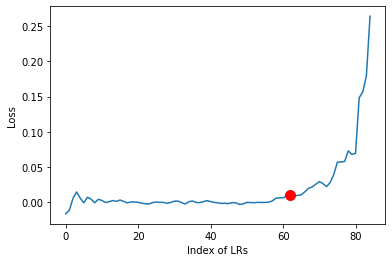

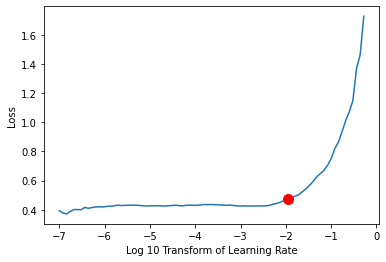

In [0]:
lr = find_appropriate_lr(learn50)

In [0]:
lr

0.01096478196143185

In [0]:
learn50.model_dir = '/tmp/model2'
learn50.fit_one_cycle(35,1e-6,callbacks=[SaveModelCallback(learn,every='improvement', monitor='f_beta')])

epoch,train_loss,valid_loss,f_beta,time
0,0.725123,0.449263,0.853336,00:20
1,0.730012,0.449557,0.851648,00:20
2,0.721957,0.448595,0.853347,00:20
3,0.717258,0.449118,0.855002,00:20
4,0.714064,0.447454,0.854159,00:20
5,0.716025,0.447334,0.850854,00:20
6,0.721252,0.449063,0.854157,00:20
7,0.715625,0.446547,0.852499,00:20
8,0.716622,0.447012,0.854128,00:20
9,0.717078,0.445654,0.854968,00:20


Better model found at epoch 0 with f_beta value: 0.8533363938331604.
Better model found at epoch 2 with f_beta value: 0.8533472418785095.
Better model found at epoch 3 with f_beta value: 0.8550015091896057.
Better model found at epoch 10 with f_beta value: 0.8558133244514465.
Better model found at epoch 13 with f_beta value: 0.8574836254119873.
Better model found at epoch 17 with f_beta value: 0.8583236336708069.
Better model found at epoch 21 with f_beta value: 0.859107494354248.
Better model found at epoch 31 with f_beta value: 0.8599900007247925.


In [0]:
learn = cnn_learner(data, models.densenet201,wd=1e-2, ps=0.5,metrics=[FBeta(beta = 4,average='weighted')], model_dir="/tmp/model",opt_func = Over9000).mixup()
learn.fit_one_cycle(100, max_lr=slice(1e-3,1e-2),callbacks=[SaveModelCallback(learn3, every='epoch', monitor='accuracy')])

epoch,train_loss,valid_loss,f_beta,time
0,1.839017,1.513109,0.237783,00:20
1,1.744819,1.439769,0.278468,00:20
2,1.672381,1.288836,0.402386,00:20
3,1.607163,1.167104,0.514747,00:20
4,1.519927,1.041611,0.581960,00:20
5,1.439806,0.952162,0.627044,00:20
6,1.361365,0.882488,0.661094,00:20
7,1.308475,0.825556,0.686769,00:20
8,1.267088,0.766180,0.711887,00:20
9,1.234894,0.724980,0.738784,00:20


In [0]:
learn.load('/tmp/model/bestmodel_86')

Learner(data=ImageDataBunch;

Train: LabelList (5086 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Food,misc,Attire,Food,misc
Path: image_auto_tagging;

Valid: LabelList (897 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Food,Food,Food,Attire,Decorationandsignage
Path: image_auto_tagging;

Test: LabelList (3219 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: image_auto_tagging, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Seque

In [0]:
preds = learn.TTA(ds_type=DatasetType.Test)
labelled_preds = []
pred13 = preds
for pred in pred13:
    labelled_preds.append(int(np.argmax(pred)))

submission1 = pd.DataFrame(
    {'Image': sub.Image.values,
     'Class': labelled_preds,
    })
submission1.to_csv('submission.csv',index=False)
import pandas as pd
import numpy as np
df =pd.read_csv('submission.csv')
a = df.Class.values
b = ['Attire', 'Decorationandsignage', 'Food', 'misc']
l = []
for i in range(len(a)):
    if a[i] == 0:
        l.append(b[0])
    if a[i] == 1:
        l.append(b[1])
    if a[i] == 2:
        l.append(b[2])
    if a[i] == 3:
        l.append(b[3])
df['Class']=pd.Series(l)
df.to_csv('submission.csv',index=False)